In [25]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

              0          1
0  ISIC_0000000     benign
1  ISIC_0000001     benign
2  ISIC_0000002  malignant
3  ISIC_0000004  malignant
4  ISIC_0000006     benign


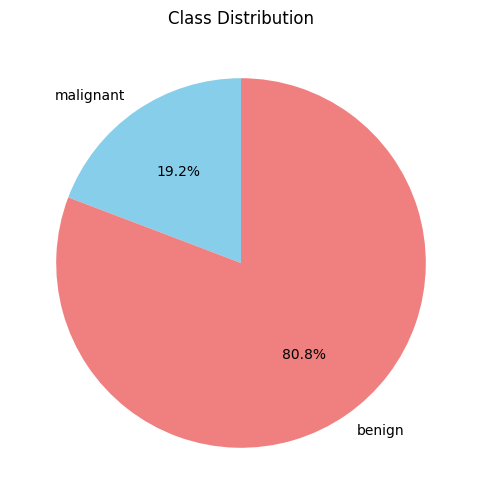

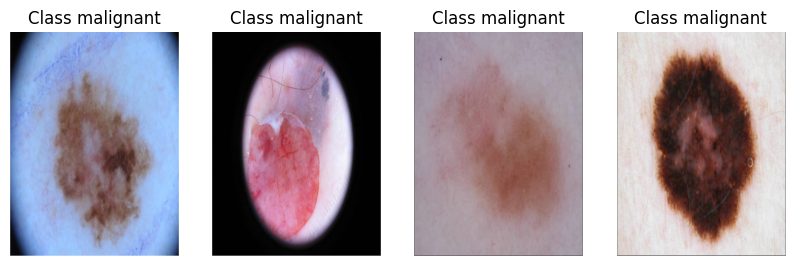

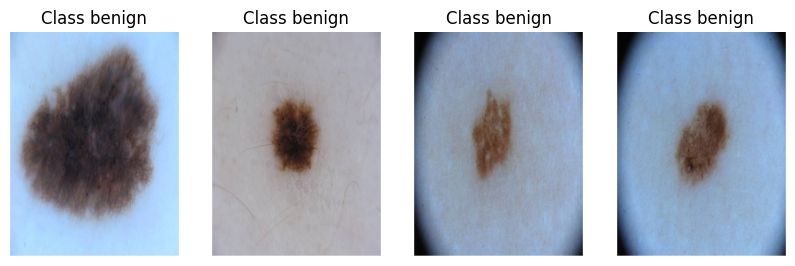

In [26]:
# Define paths
train_images_path = r'C:\Users\praya\Vol D Backup\Semester 5\ML\Project\ISIC 2016 Dataset_4\isic 2016\ISBI2016_ISIC_Part1_Training_Data/'
train_groundtruth_path = r'C:\Users\praya\Vol D Backup\Semester 5\ML\Project\ISIC 2016 Dataset_4\isic 2016\ISBI2016_ISIC_Part3B_Training_GroundTruth.csv'

# Load ground truth data without headers
train_groundtruth = pd.read_csv(train_groundtruth_path, header=None)

# Preview ground truth data
print(train_groundtruth.head())

# Manually assign column names
train_groundtruth.columns = ['image_id', 'label']  # Assign meaningful names

# Load images
image_size = (767, 1022)  # Resize dimensions
image_data = []
labels = []

# Now you can use these column names in the rest of your code
for index, row in train_groundtruth.iterrows():
    image_name = row['image_id']  # Column for image identifier
    label = row['label']  # Column for label
    
    # Load the image
    image_path = os.path.join(train_images_path, image_name + '.jpg') # Adjust file extension if needed
    image = cv2.imread(image_path)
    
    if image is not None:
        # Resize the image
        image_resized = cv2.resize(image, image_size)
        
        # Append the image and label to lists
        image_data.append(image_resized)
        labels.append(label)
    else:
        print(f"Image {image_name} not found.")

# Convert labels list to a numpy array\

# Plot the class distribution as a pie chart
class_counts = [labels.count("malignant"),labels.count("benign")]
class_labels = ['malignant', 'benign']  # Adjust if needed

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.show()

# Function to plot images from each class
def plot_class_images(image_data, labels, class_value, num_images=4):
    plt.figure(figsize=(10, 10))
    class_indices = [i for i, label in enumerate(labels) if label == class_value]
    
    for i in range(min(num_images, len(class_indices))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(image_data[class_indices[i]], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Class {class_value}')
    
    plt.show()

# Plot 4 images from Class 0
plot_class_images(image_data, labels, class_value=class_labels[0], num_images=4)

# Plot 4 images from Class 1
plot_class_images(image_data, labels, class_value=class_labels[1], num_images=4)

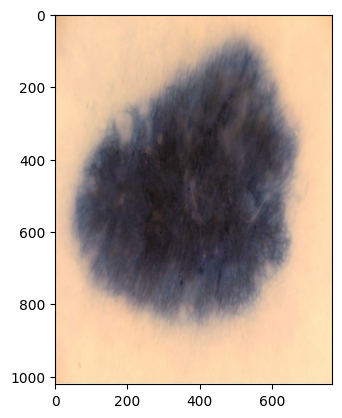

In [27]:
plt.imshow(image_data[0])
plt.show()

Our image has been resized to (767 x 1022) pixels. Image matrix is in form (height x width x 3), where 3 represents 3 channels for RGB color values each in range [0, 255]. 0 -> no intensity (darkest), 255 -> full intensity (brightest).
3-dim array -> height x width x [R G B]

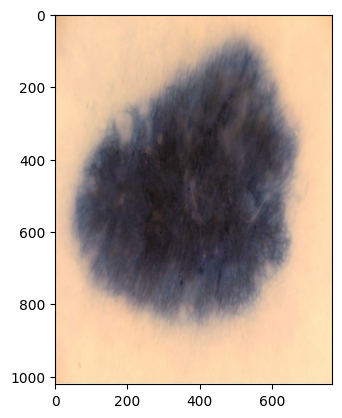

In [28]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image_data[0])
plt.show()


Kernel is rectangular-shaped structuring elt, here (17 x 17) pixels. It can be adjusted depending in thickness of hair. Large kernels for thicker hair and smaller kernels for fine hair are better.

Blackhat -> black-hat morphological op, highlights dark features(like hair) on lighter background by subtracting opening of img from org img.
blackhat contains hair detected in img.

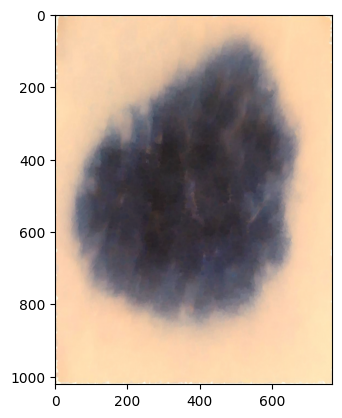

In [29]:
def preprocess_image(image):
    # Noise removal (3x3 median filter) -> replace each pixel value with median of surrounding pixels within 3x3 region.
    image_denoised = cv2.medianBlur(image, 3) # Median filter commonly used for 'salt and pepper' noise, which consists bright and dark pixels scattered throghout the image.
    
    # Convert image to grayscale for hair removal, since it is easier to do hair removal on grayscale images
    gray_image = cv2.cvtColor(image_denoised, cv2.COLOR_BGR2GRAY)
    
    # Hair removal using bottom-hat filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))  # Adjust size based on hair thickness
    blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)
    
    # Inpainting to fill in the removed hair, blackhat img used as mask to fill in the hair
    image_inpainted = cv2.inpaint(image, blackhat, 1, cv2.INPAINT_TELEA) # TELEA used for filling small missing parts by propagating picel info around surrounding areas.
    
    return image_inpainted

# Example: Apply preprocessing to all images
preprocessed_images = [preprocess_image(img) for img in image_data]
plt.imshow(preprocessed_images[0])
plt.show()


# Contrast Streching

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[212 249 255]
  [212 249 255]
  [216 254 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


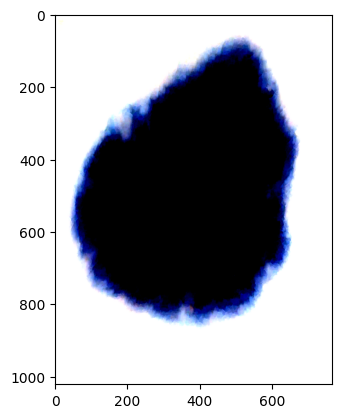

In [30]:
import numpy as np

def contrast_stretching(image):
    # Split image into R, G, B channels
    r, g, b = cv2.split(image)
    
    def stretch_channel(channel):
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        low_in = mean_val - 0.4 * std_val      # lower limit of pixel values for contrast stretching
        high_in = mean_val + 0.4 * std_val     # upper limit of pixel values for contrast stretching
        stretched = np.clip((channel - low_in) * (255 / (high_in - low_in)), 0, 255)  # 
        return stretched.astype(np.uint8)
    
    # Apply stretching to each channel
    r_stretched = stretch_channel(r)
    g_stretched = stretch_channel(g)
    b_stretched = stretch_channel(b)
    
    # Merge the channels back
    return cv2.merge([r_stretched, g_stretched, b_stretched])

# Example: Apply contrast stretching to preprocessed images
contrast_stretched_images = [contrast_stretching(img) for img in preprocessed_images]

print(contrast_stretched_images[0])
plt.imshow(contrast_stretched_images[0])
# plt.imshow(contrast_stretched_images[1])
plt.show()
# print(contrast_stretched_images[1])
# print(contrast_stretched_images[2])

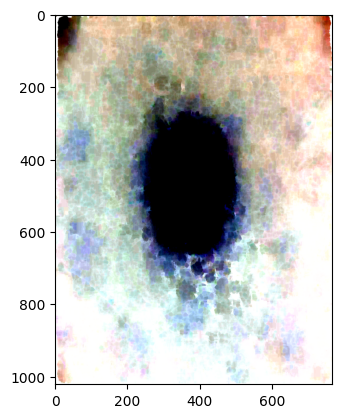

In [31]:
plt.imshow(contrast_stretched_images[1])
plt.show()

# Segmentation

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


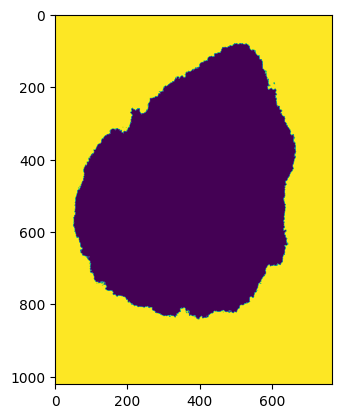

In [32]:
def otsu_thresholding(image):
    # Convert image to grayscale if not already
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply OTSU thresholding
    _, segmented_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return segmented_image

# Example: Apply OTSU thresholding to contrast-stretched images
segmented_images = [otsu_thresholding(img) for img in contrast_stretched_images]

print(segmented_images[0])
plt.imshow(segmented_images[0])
plt.show()


# Feature Extraction
-------------

# *Texture Features (GLCM - Gray Level Co-occurrence Matrix)*

In [33]:
from skimage.feature import graycomatrix, graycoprops
import numpy as np
import cv2

def extract_glcm_features(image):
    # Check if the image is already grayscale
    if len(image.shape) == 3:  # If the image has 3 channels (RGB)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # If the image is already grayscale
        gray_image = image

    # Compute GLCM at multiple angles (0°, 45°, 90°, 135°)
    glcm = graycomatrix(gray_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)

    # Extract basic GLCM properties
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    asm = graycoprops(glcm, 'ASM')  # Angular Second Moment

    # Additional custom GLCM features
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))  # Entropy calculation
    
    # Corrected autocorrelation calculation by reducing axes
    levels = glcm.shape[0]  # Number of gray levels (usually 256)
    i, j = np.ogrid[:levels, :levels]  # Create index arrays
    autocorrelation = np.sum(glcm * (i * j)[:, :, None, None], axis=(0, 1))

    cluster_shade = np.sum(((i + j)[:, :, None, None] - np.mean(glcm))**3 * glcm, axis=(0, 1))
    cluster_prominence = np.sum(((i + j)[:, :, None, None] - np.mean(glcm))**4 * glcm, axis=(0, 1))
    max_probability = np.max(glcm)  # Maximum Probability
    idm = np.sum(glcm / (1 + (i - j)**2)[:, :, None, None], axis=(0, 1))  # Inverse Difference Moment (IDM)
    sum_average = np.sum((i + j)[:, :, None, None] * glcm, axis=(0, 1))  # Sum Average
    sum_variance = np.var((i + j)[:, :, None, None] * glcm, axis=(0, 1))  # Sum Variance

    # Combine all features into a dictionary
    features = {
        'contrast': contrast.mean(),
        'dissimilarity': dissimilarity.mean(),
        'homogeneity': homogeneity.mean(),
        'energy': energy.mean(),
        'correlation': correlation.mean(),
        'asm': asm.mean(),  # Angular Second Moment
        'entropy': entropy.mean(),
        'autocorrelation': autocorrelation.mean(),
        'cluster_shade': cluster_shade.mean(),
        'cluster_prominence': cluster_prominence.mean(),
        'max_probability': max_probability,
        'idm': idm.mean(),  # Inverse Difference Moment
        'sum_average': sum_average.mean(),
        'sum_variance': sum_variance.mean()
    }

    return features

# for i in range(len(segmented_images)):
#     glcm_features = extract_glcm_features(i)
# Example: Extract GLCM features for one image
# glcm_features = extract_glcm_features(contrast_stretched_images[0])

# # Print all extracted GLCM features
# for feature_name, feature_value in glcm_features.items():
#     print(f'{feature_name}: {feature_value}')

# print(len(glcm_features))  # Total number of features extracted


# *Color Features*

Given table in research paper provided 36 color features across different color spaces (*RGB, HSV, LAB*). We'll extract mean, variance, skewness, and kurtosis from each channel in these color spaces.

In [34]:
from scipy.stats import skew, kurtosis
import cv2
import numpy as np

def extract_color_features(image):
    # Check if the image has 3 channels (RGB)
    if len(image.shape) == 3 and image.shape[2] == 3:  # Ensure the image is not grayscale
        # Convert the image to different color spaces
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
        rgb_image = image  # Keep the original RGB
    else:
        raise ValueError("Input image must be a color image with 3 channels (RGB)")

    # Function to calculate color statistics (mean, variance, skewness, kurtosis)
    def calculate_statistics(channel):
        return {
            'mean': np.mean(channel),
            'variance': np.var(channel),
            'skewness': skew(channel.flatten()),
            'kurtosis': kurtosis(channel.flatten())
        }

    # Initialize dictionary to store all features
    features = {}

    # Extract statistics for each channel in RGB
    for i, color in enumerate(['R', 'G', 'B']):
        stats = calculate_statistics(rgb_image[:, :, i])
        for stat, value in stats.items():
            features[f'{stat}_{color}'] = value

    # Extract statistics for each channel in HSV (Hue, Saturation, Value)
    for i, color in enumerate(['H', 'S', 'V']):
        stats = calculate_statistics(hsv_image[:, :, i])
        for stat, value in stats.items():
            features[f'{stat}_{color}'] = value

    # Add specific hue-based statistics
    hue_channel = hsv_image[:, :, 0]  # Hue channel
    features['mean_hue'] = np.mean(hue_channel)
    features['variance_hue'] = np.var(hue_channel)
    features['skewness_hue'] = skew(hue_channel.flatten())
    features['kurtosis_hue'] = kurtosis(hue_channel.flatten())

    # Extract statistics for each channel in Lab (L, A, B)
    for i, color in enumerate(['L', 'A', 'B']):
        stats = calculate_statistics(lab_image[:, :, i])
        for stat, value in stats.items():
            features[f'{stat}_{color}'] = value

    return features

# for i in range(len(segmented_images)):
#     color_features = extract_color_features(i)
# Example: Extract color features for one image
# color_features = extract_color_features(contrast_stretched_images[0])

# # Print all extracted features (including the hue-based features)
# for feature_name, feature_value in color_features.items():
#     print(f'{feature_name}: {feature_value}')

# print(len(color_features))  # Total number of features extracted


# *HOG Features*

In [35]:
from skimage.feature import hog
from skimage import exposure
import cv2

def extract_hog_features(image):
    # Resize the image for uniform HOG feature extraction
    resized_image = cv2.resize(image, (96, 128))

    # Extract HOG features
    if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
        hog_features, hog_image = hog(resized_image, pixels_per_cell=(8, 8), 
                                      cells_per_block=(1, 1), visualize=True, 
                                      orientations=18,  # Reduce orientations
                                      channel_axis=-1)
    else:
        hog_features, hog_image = hog(resized_image, pixels_per_cell=(8, 8), 
                                      cells_per_block=(1, 1), visualize=True, 
                                      orientations=18,  # Reduce orientations
                                      channel_axis=None)  # For grayscale images

    return hog_features

# for i in range(len(segmented_images)):
#     hog_features = extract_hog_features(segmented_images[i])

# Example: Extract HOG features for one image
# hog_features = extract_hog_features(segmented_images[0])
# print(hog_features)
# print(hog_features.shape)


In [36]:
# Function to process each image and extract all features
def extract_features_for_dataset(contrast_streched_images, segmented_images):
    data = []
    
    # Loop through each pair of images in contrast_streched_images and segmented_images
    for i in range(len(contrast_streched_images)):
        # Extract color features from RGB image (contrast_streched_images)
        color_features = extract_color_features(contrast_streched_images[i])
        
        # Extract GLCM and HOG features from grayscale image (segmented_images)
        glcm_features = extract_glcm_features(segmented_images[i])
        hog_features = extract_hog_features(segmented_images[i])
        
        # Combine all features into a single dictionary
        features = {**color_features, **glcm_features, 'hog_features': hog_features}
        features['image_index'] = i  # Add image index for reference
        
        # Append the features to the dataset
        data.append(features)
    
    # Convert to DataFrame and expand HOG features
    df = pd.DataFrame(data)
    hog_df = pd.DataFrame(df['hog_features'].to_list(), index=df.index, columns=[f'hog_{i}' for i in range(len(df['hog_features'][0]))])
    
    # Concatenate HOG features with the main DataFrame
    final_df = pd.concat([df.drop(columns=['hog_features']), hog_df], axis=1)
    
    return final_df

# Assuming contrast_streched_images and segmented_images are lists of pre-processed images
features_df = extract_features_for_dataset(contrast_stretched_images, segmented_images)

# Save the features to a CSV file
features_df.to_csv('New_Image_Features.csv', index=False)

In [37]:
from sklearn.decomposition import PCA

# Extract the HOG features (those columns start with 'hog_')
hog_columns = [col for col in features_df.columns if col.startswith('hog_')]
hog_features = features_df[hog_columns]

# Apply PCA to reduce the HOG features from 3456 dimensions to 100
pca = PCA(n_components=100)
reduced_hog_features = pca.fit_transform(hog_features)

# Create a DataFrame for the reduced HOG features
reduced_hog_df = pd.DataFrame(reduced_hog_features, columns=[f'pca_hog_{i}' for i in range(100)])

# Combine the reduced HOG features with the original non-HOG features
non_hog_columns = [col for col in features_df.columns if not col.startswith('hog_')]
non_hog_features = features_df[non_hog_columns]
final_df = pd.concat([non_hog_features, reduced_hog_df], axis=1)
# Add the labels as a new column in the final DataFrame
# final_df['label'] = labels

# Save the final D ataFrame to a new CSV file
output_file_path = 'reduced_new_image_features.csv'
final_df.to_csv(output_file_path, index=False)

output_file_path  # Return the path to the newly saved file


'reduced_new_image_features.csv'

# *SMOTE Sampling and Standard Scaling*

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 0: Load the dataset
file_path = 'reduced_new_image_features.csv'  # Replace with the actual path
data = pd.read_csv(file_path)

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

# Step 2: Apply SMOTE to balance the training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Feature scaling (Standardization)
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


# RF

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 4: Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, verbose = 3)  # You can adjust the number of estimators if needed

# Train the model
rf_classifier.fit(X_train_scaled, y_train_resampled)

# Step 5: Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the performance metrics
print("Accuracy of Random Forest Classifier: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 1 of 1000building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000

building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.4s


building tree 153 of 1000building tree 154 of 1000

building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.1s


building tree 323 of 1000building tree 324 of 1000

building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.0s


building tree 546 of 1000
building tree 547 of 1000
building tree 548 of 1000
building tree 549 of 1000
building tree 550 of 1000
building tree 551 of 1000
building tree 552 of 1000
building tree 553 of 1000
building tree 554 of 1000
building tree 555 of 1000
building tree 556 of 1000
building tree 557 of 1000
building tree 558 of 1000
building tree 559 of 1000
building tree 560 of 1000
building tree 561 of 1000
building tree 562 of 1000
building tree 563 of 1000
building tree 564 of 1000
building tree 565 of 1000
building tree 566 of 1000
building tree 567 of 1000
building tree 568 of 1000
building tree 569 of 1000
building tree 570 of 1000
building tree 571 of 1000
building tree 572 of 1000
building tree 573 of 1000
building tree 574 of 1000
building tree 575 of 1000
building tree 576 of 1000
building tree 577 of 1000
building tree 578 of 1000
building tree 579 of 1000
building tree 580 of 1000
building tree 581 of 1000
building tree 582 of 1000
building tree 583 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.1s


building tree 825 of 1000building tree 826 of 1000

building tree 827 of 1000
building tree 828 of 1000
building tree 829 of 1000
building tree 830 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 833 of 1000
building tree 834 of 1000
building tree 835 of 1000
building tree 836 of 1000
building tree 837 of 1000
building tree 838 of 1000
building tree 839 of 1000
building tree 840 of 1000
building tree 841 of 1000
building tree 842 of 1000
building tree 843 of 1000
building tree 844 of 1000
building tree 845 of 1000
building tree 846 of 1000
building tree 847 of 1000
building tree 848 of 1000
building tree 849 of 1000
building tree 850 of 1000
building tree 851 of 1000
building tree 852 of 1000
building tree 853 of 1000
building tree 854 of 1000
building tree 855 of 1000
building tree 856 of 1000
building tree 857 of 1000
building tree 858 of 1000
building tree 859 of 1000
building tree 860 of 1000
building tree 861 of 1000
building tree 862 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Accuracy of Random Forest Classifier: 74.44%

Confusion Matrix:
 [[127  18]
 [ 28   7]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.82      0.88      0.85       145
   malignant       0.28      0.20      0.23        35

    accuracy                           0.74       180
   macro avg       0.55      0.54      0.54       180
weighted avg       0.71      0.74      0.73       180



# LR

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 4: Train a Logistic Regression Classifier
logreg_classifier = LogisticRegression(max_iter=1000, random_state=42)  # Adjust max_iter if convergence issues arise

# Train the model
logreg_classifier.fit(X_train_scaled, y_train_resampled)

# Step 5: Make predictions on the test set
y_pred = logreg_classifier.predict(X_test_scaled)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the performance metrics
print("Accuracy of Logistic Regression Classifier: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy of Logistic Regression Classifier: 66.11%

Confusion Matrix:
 [[100  45]
 [ 16  19]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.86      0.69      0.77       145
   malignant       0.30      0.54      0.38        35

    accuracy                           0.66       180
   macro avg       0.58      0.62      0.58       180
weighted avg       0.75      0.66      0.69       180



# SVM

In [41]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 4: Train an SVM Classifier
# svm_classifier = SVC(kernel='rbf', C=10, gamma=1.0, random_state=42)
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)

# Train the model
svm_classifier.fit(X_train_scaled, y_train_resampled)

# Step 5: Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the performance metrics
print("Accuracy of SVM Classifier: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy of SVM Classifier: 75.00%

Confusion Matrix:
 [[128  17]
 [ 28   7]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.82      0.88      0.85       145
   malignant       0.29      0.20      0.24        35

    accuracy                           0.75       180
   macro avg       0.56      0.54      0.54       180
weighted avg       0.72      0.75      0.73       180



In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 1: Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],            # Regularization parameter
    'gamma': ['scale', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['linear', 'rbf']    # Kernel type
}

# Step 2: Initialize the SVM classifier
svm = SVC(random_state=42)

# Step 3: Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Step 4: Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train_resampled)

# Step 5: Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_ * 100))

# Step 6: Evaluate the best model on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the performance metrics
print("Accuracy of Tuned SVM Classifier: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 97.25%
Accuracy of Tuned SVM Classifier: 78.33%

Confusion Matrix:
 [[140   5]
 [ 34   1]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.80      0.97      0.88       145
   malignant       0.17      0.03      0.05        35

    accuracy                           0.78       180
   macro avg       0.49      0.50      0.46       180
weighted avg       0.68      0.78      0.72       180



# QDA

In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 4: Train a QDA Classifier
qda_classifier = QuadraticDiscriminantAnalysis(reg_param=0.1)

# Train the model
qda_classifier.fit(X_train_scaled, y_train_resampled)

# Step 5: Make predictions on the test set
y_pred = qda_classifier.predict(X_test_scaled)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the performance metrics
print("Accuracy of QDA Classifier: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy of QDA Classifier: 79.44%

Confusion Matrix:
 [[142   3]
 [ 34   1]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.81      0.98      0.88       145
   malignant       0.25      0.03      0.05        35

    accuracy                           0.79       180
   macro avg       0.53      0.50      0.47       180
weighted avg       0.70      0.79      0.72       180



c:\Users\praya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [44]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 4: Train a QDA Classifier with adjusted parameters
qda_classifier = QuadraticDiscriminantAnalysis(reg_param=0.1, tol=0.0001)
# reg_param adds regularization (try values between 0 and 1)
# tol is the tolerance for detecting singularity in the covariance matrix

# Train the model
qda_classifier.fit(X_train_scaled, y_train_resampled)

# Step 5: Make predictions on the test set
y_pred = qda_classifier.predict(X_test_scaled)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the performance metrics
print("Accuracy of QDA Classifier with adjusted parameters: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


c:\Users\praya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy of QDA Classifier with adjusted parameters: 79.44%

Confusion Matrix:
 [[142   3]
 [ 34   1]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.81      0.98      0.88       145
   malignant       0.25      0.03      0.05        35

    accuracy                           0.79       180
   macro avg       0.53      0.50      0.47       180
weighted avg       0.70      0.79      0.72       180

